## Task

Given the files that have data in format $t: [\lambda: I]$, transform the data to $\lambda: [t: \Delta \text{OD}]$. The relationships between the values are:

\begin{align}
  \Delta \text{OD} &= \text{OD} - \text{OD}_{\text{ground}},\\
  \text{OD} &= \lg \dfrac{I_0}{I},\\
  \text{OD}_{\text{ground}} &= \lg \dfrac{I_0}{I_{\text{ground}}},
    \end{align}
where $I_{\text{ground}}$ are taken from х_before.abs/x_after.abs, $I_0$ from x.buf, $I$ from x_y.fp. Here x -- global experiment number, y -- run number.


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
from tqdm import tqdm

# ignores pandas deprication warnings
import warnings
warnings.filterwarnings('ignore')

In [137]:
# global experiment number given by the system
EXPERIMENT = 1832

# pats to files, by default the structure is
# ├── code.ipynb
# ├── EXPERIMENT
# │   ├── EXPERIMENT.buf
# │   ├── EXPERIMENT_n.fp
# │   ├── EXPERIMENT_ave.buf
# │   ├── EXPERIMENT_ave_after.buf
# │   ├── EXPERIMENT_ave_before.buf
# │   ├── EXPERIMENT_after.buf
# │   └── EXPERIMENT_before.buf
ABS = INTENSITY = GROUND = os.path.join(os.getcwd(), str(EXPERIMENT))

# number of runs
NUMBER_OF_FILES = 100 

# constant number of measurements for one run
NUMBER_OF_ROWS_FOR_ONE_MEASUREMENT = 1609

# number of runs for the ground and buffer measurements
NUMBER_OF_GROUND_RUNS = 100

# we have two ground spectra measurements: before and after the experiment
# this variable controls whether we take the former or the latter one
IS_BEFORE = False

# Open .fp files to `fp_files`

In [138]:
# getting .fp files
fp_files = []
for idx in tqdm(range(0, NUMBER_OF_FILES)):
    df_wavelength_intensity = pd.read_csv(os.path.join(INTENSITY, f"{EXPERIMENT}_{idx+1}.fp"), sep="\s+", header=None)

    # one .fp has NUMBER_OF_ROWS_FOR_ONE_MEASUREMENT runs, split them up
    arr = [df_wavelength_intensity.reset_index(drop=True) for df_wavelength_intensity in np.array_split(df_wavelength_intensity, df_wavelength_intensity.shape[0] // NUMBER_OF_ROWS_FOR_ONE_MEASUREMENT)]
    
    # we have a random starting time, like 14124325
    start_time = arr[0][1].iloc[-1]

    for df_wavelength_intensity in arr:
        # zero out the measurement times, based on the starting one, so that the end result is not
        # 1453252, 1453752, 1454252, 1454752... 
        # but
        # 0, 500, 1000, 1500....
        df_wavelength_intensity[1].iloc[-1] -= start_time

        # remove a random increment that gets added because of equipment lag 
        # (i.e final times were not
        # 500, 1000, 1500, ..., 10000, 10500, ..., 1260000
        # but
        # 500, 1000, 1501, ..., 10001, 10501, ..., 126005)
        df_wavelength_intensity[1].iloc[-1] = int( round(df_wavelength_intensity[1].iloc[-1] / 100) ) * 100

    # store in a common array
    fp_files.append(arr)


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


# Choose wavelengths for reduction

In [139]:
# pick the indecies to cut off at
START_IDX = 120
FINISH_IDX = 1070
DELTA_IDX = 4

In [140]:
fp_files_reduced = []
for file in tqdm(fp_files):
    file_new = []
    for df_wavelength_intensity in file:
        file_new.append( 
            pd.concat(
                [df_wavelength_intensity[START_IDX : FINISH_IDX : DELTA_IDX], 
                 df_wavelength_intensity[-1:]]).reset_index(drop=True)
        )
    fp_files_reduced.append(file_new)
        

100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


# Open .buf file to `df_buf`

In [141]:
# getting the .buf file with the buffer spectrum
data_buf = pd.read_csv(os.path.join(ABS, f"{EXPERIMENT}.buf"), sep="\s+", header=None)

# one .abs has NUMBER_OF_GROUND_RUNS runs, split them up
split_buf = [df.reset_index(drop=True) for df in np.array_split(data_buf, NUMBER_OF_GROUND_RUNS)]

# average out the runs
average_df = pd.DataFrame()
for i, df in enumerate(split_buf):
    average_df[f'df_{i}'] = df.iloc[:-1, 1] # drop the time row
average_df['average'] = average_df.mean(axis=1)

df_buf = pd.DataFrame({0: split_buf[0].iloc[:-1,0], 1: average_df['average']})

# Open .abs file to `df_ground`

In [142]:
# getting the .abs file with the ground spectrum
# we either take the before or after spectrum
df_before = pd.read_csv(os.path.join(ABS, f"{EXPERIMENT}_before.abs"), sep="\s+", header=None)
df_after = pd.read_csv(os.path.join(ABS, f"{EXPERIMENT}_after.abs"), sep="\s+", header=None)

data_ground = df_before if IS_BEFORE else df_after

# one .abs has NUMBER_OF_GROUND_RUNS runs, split them up
split_ground = [df.reset_index(drop=True) for df in np.array_split(data_ground, NUMBER_OF_GROUND_RUNS)]

# average out the runs
average_df = pd.DataFrame()
for i, df in enumerate(split_ground):
    average_df[f'df_{i}'] = df.iloc[:-1, 1] # drop the time row
average_df['average'] = average_df.mean(axis=1)

df_ground = pd.DataFrame({0: split_ground[0].iloc[:-1,0], 1: average_df['average']})

df_ground_reduced = df_ground[START_IDX : FINISH_IDX : DELTA_IDX].reset_index(drop=True)

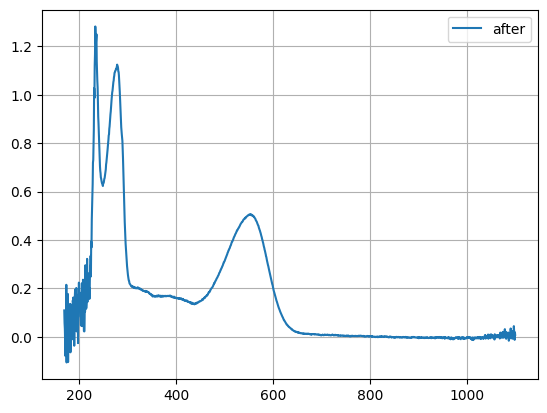

In [143]:
# plot ground spectra comparison
plt.plot(df_buf[0], np.log10(df_buf[1]/df_ground[1]), label='after')
# plt.plot(df_buf[0], np.log10(df_buf[1]/df_before[1]), label='before')
plt.grid()
plt.legend()
plt.savefig(os.path.join('ABS', f"{EXPERIMENT}_after_all_WLs.png"))
plt.show()

In [144]:
# save ABS files for further analysis
np.savetxt(
    os.path.join('ABS', f"{EXPERIMENT}_before_all_WLs.abs"),
    np.transpose([df_buf[0], np.log10(df_buf[1]/df_ground[1])]),
    fmt=['%.3f', '%f']
)

np.savetxt(
    os.path.join('ABS', f"{EXPERIMENT}_before.abs"),
    np.transpose([df_buf[0], np.log10(df_buf[1]/df_ground[1])])[START_IDX : FINISH_IDX],
    fmt=['%.3f', '%f']
)

# Make `result_dict`: ordred by wavelength

In [145]:
# we get all wavelength that were measured 
wavelengths = fp_files_reduced[0][1].iloc[:-1, 0]
dataframe_dict = defaultdict(list)
result_dict = defaultdict(list)

# for each wavelength, combine the intesity values for diffenrent times into one series 
for arr in tqdm(fp_files_reduced):
    for dataframe in arr:
        wavelength_values = dataframe.iloc[:-1, 0].values  # drop the time row
        intensity_values = dataframe.iloc[:-1, 1].values   # drop the time row
        experiment_time = dataframe.iloc[-1, 1]

        for wavelength, intensity in zip(wavelength_values, intensity_values):
            # if wavelength in dataframe_dict:
            dataframe_dict[wavelength].append((experiment_time, intensity))
            # else:
            #     dataframe_dict[wavelength] = [(experiment_time, intensity)]

    for wavelength, values in dataframe_dict.items():
        time_values, intensity_values = zip(*values)
        df = pd.DataFrame({'time': time_values, 'intensity': intensity_values})
        result_dict[wavelength].append(df.reset_index(drop=True))


    dataframe_dict.clear()

100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


In [146]:
# check the result
len(result_dict[wavelengths[0]])

100

# Make `new_data`: mean intensities

What we have now as a ```result_dict``` is a dictionary with key-value pairs of
$
\lambda: [t: I]
$. What's left to do now is to use

\begin{align}
  \Delta \text{OD} &= \text{OD} - \text{OD}_{\text{ground}},\\
  \text{OD} &= \lg \dfrac{I_0}{I},\\
  \text{OD}_{\text{ground}} &= \lg \dfrac{I_0}{I_{\text{ground}}},
\end{align}

to transform it into 
$
\lambda: [t: \Delta \text{OD}]
$

The variables correspond to:

```result_dict``` $\lambda: [t, I]$,

```df_before``` $[\lambda, I_{\text{ground}}]$, 

```df_buf``` $[\lambda, I_0]$.

In [147]:
# make a set for a faster look-up time
used_wavelengths = set(wavelengths.reset_index(drop=True))

new_data = {}
for wavelength, dataframes in tqdm(result_dict.items()):
    # skip most of the wavelengths
    if wavelength not in used_wavelengths:
        continue

    # group by 'time' and then mean out
    df = pd.concat(dataframes)
    new_data[wavelength] = df.groupby('time').mean().reset_index()

100%|██████████| 238/238 [00:00<00:00, 249.10it/s]


# Plot Intensity vs Time for one wavelength

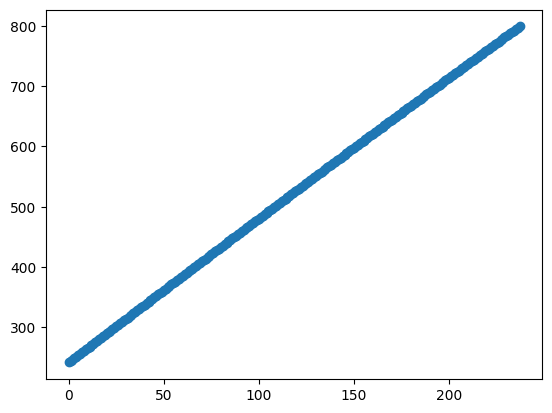

In [148]:
plt.plot(wavelengths, 'o')
plt.show()

In [149]:
# check wavelength list
wavelengths

0      242.018
1      244.426
2      246.833
3      249.240
4      251.646
        ...   
233    789.611
234    791.893
235    794.175
236    796.456
237    798.737
Name: 0, Length: 238, dtype: float64

In [150]:
# test wavelength index
WAVELENGTH = 120
wavelengths[WAVELENGTH]

527.688

### Plot from `result_dict`

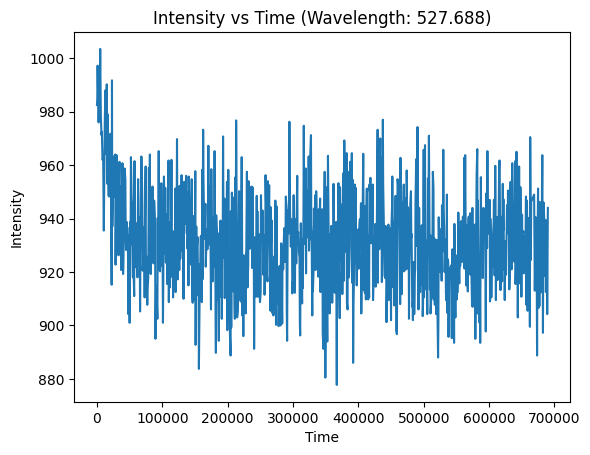

In [151]:
# * Optional
# test one wavelength
wavelength = wavelengths[WAVELENGTH]
df = result_dict[wavelength][0]

time_values = df['time'].values
intensity_values = df['intensity'].values

plt.plot(time_values, intensity_values)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Intensity vs Time (Wavelength: {wavelength})')
plt.show()

### Plot from `fp_files_reduced`

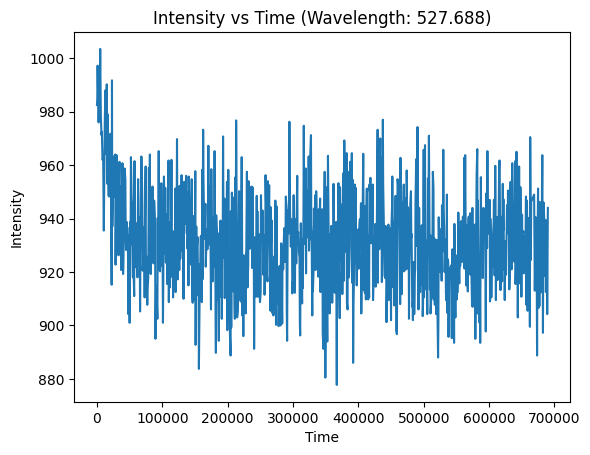

In [152]:
# test compare with manual picking
intensities = []
times = []
arr = fp_files_reduced[0]
for df in arr:
    times.append(df.iloc[-1, 1])
    intensities.append(df.iloc[WAVELENGTH, 1])

plt.plot(times, intensities)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Intensity vs Time (Wavelength: {df.iloc[WAVELENGTH, 0]})')
plt.show()


## Plot from `new_data`

527.688


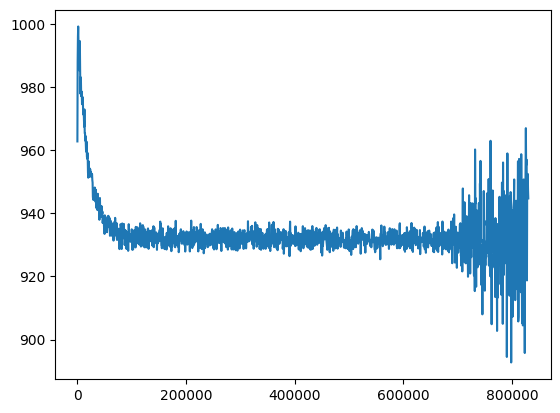

In [153]:
wls = list(used_wavelengths)
wls.sort()
wl = wls[WAVELENGTH]
print(wl)
plt.plot(new_data[wl]["time"], new_data[wl]["intensity"])
plt.show()

# new_data[wl]

## Plot Delta_OD

527.688


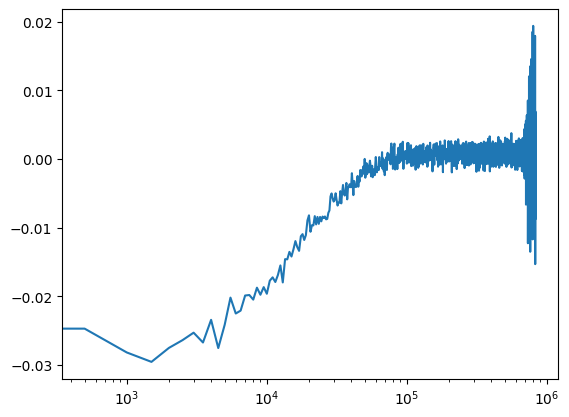

In [154]:
sample_wavelength = wls[WAVELENGTH]
print(sample_wavelength)

df_sample_wavelength = new_data[sample_wavelength]

df_before_sample_wavelength_index = df_ground_reduced.loc[df_ground_reduced[0] == sample_wavelength].index

ground_intensity = df_ground_reduced.iloc[df_before_sample_wavelength_index, 1].values[0]
od_col = -np.log10(df_sample_wavelength["intensity"].div(ground_intensity))

plt.plot(df_sample_wavelength["time"], od_col)
plt.xscale("log")
plt.show()

# function `log_compress`

In [155]:
# a basic logarithmic compresssin algorithm
def log_compress(one_wl):
    data = np.array(one_wl)
    rows_number = 100
    averaging_window = 2
    rows_used = rows_number
    new_data = data[:rows_number]
    i = 0

    # iteratively add averaged rows
    while(rows_used < data.shape[0]):
        new_data = np.append(new_data, [np.mean(data[rows_used : rows_used + averaging_window], axis=0)], axis=0)
        rows_used += averaging_window
        i += 1
        if i == rows_number:
            i = 0
            averaging_window *= 2
            
    # convert back to the data frame
    res = pd.DataFrame(new_data, columns=one_wl.columns)
    res['index'] = range(1, res.shape[0] + 1)
    return res

## Plot log_compressed

527.688


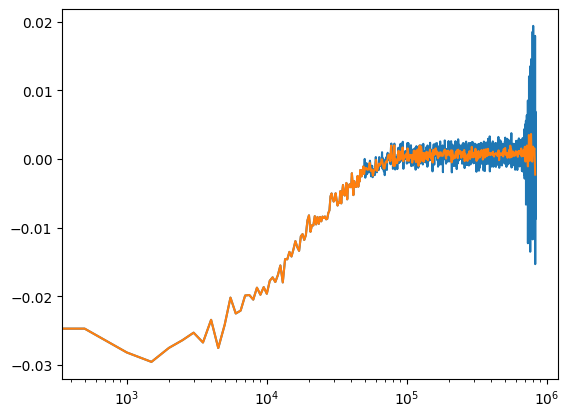

In [156]:
# pick a sampled wavelength
sample_wavelength = wls[WAVELENGTH]
print(sample_wavelength)

# pick a corresponding df
df_sample_wavelength = new_data[sample_wavelength]

# pick the corresponding ground spectra
df_ground_sample_wavelength_index = df_ground_reduced.loc[df_ground_reduced[0] == sample_wavelength].index
ground_intensity = df_ground_reduced.iloc[df_ground_sample_wavelength_index, 1].values[0]

# compared to compressed
df_sample_wavelength["OD"] = -np.log10(df_sample_wavelength["intensity"].div(ground_intensity))
df_comressed = log_compress(df_sample_wavelength)

plt.plot(df_sample_wavelength["time"], df_sample_wavelength["OD"])
plt.plot(df_comressed["time"], df_comressed["OD"])
plt.xscale("log")
plt.show()

# Make `final_data` with Delta_OD

We got what we wanted, we have a ```new_data``` dictionary where the keys are wavelengths and the values are pd.DataFrames with columns ```time``` (Time, µs) and ```intensity``` ($\Delta\text{OD}$, a.u.). It's just a matter of making .DAT files similar to what we get with PMT measurements. They have four columns, 

```index, time, intensity, weight```, 

where we ignore the last one and just make it 500 everywhere. The dataframes are separated by lines that indicate the wavelength 

```-1 wavelength 0 0 0```


In [157]:
concat_list = []

for wavelength, df in new_data.items():
    # add missing columns
    df['weight'] = 500  
    df['index'] = range(0, df.shape[0]) 
    
    # wavelength row
    separator_row = pd.DataFrame({'index': [-1], 'time': [wavelength], 'intensity': [0], 'weight': [0]})
    
    # calculate the assosiated ground intensity and calculate delta OD
    df_ground_sample_wavelength_index = df_ground_reduced.loc[df_ground_reduced[0] == wavelength].index
    ground_intensity = df_ground_reduced.iloc[df_ground_sample_wavelength_index, 1].values[0]
    df["intensity"] = -np.log10(df["intensity"].div(ground_intensity))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    df_res = df[1:]
    df_res = log_compress(df_res)
    
    concat_list.extend([df_res, separator_row])

# join the list together
final_data = pd.concat(concat_list, ignore_index=True)

# reorder columns to the INPU.dat order
final_data = final_data[['index', 'time', 'intensity', 'weight']]



# Write to file

In [158]:
output_file = f'INPU{EXPERIMENT}.DAT'

# make a .txt file with five spaces as separators, so it resembles INPU.dat files
np.savetxt(
    output_file,
    final_data.values,
    delimiter='     ',
    header='',
    fmt=['%d', '%.4f', '%f', '%d'],
    encoding=None)
